# <center> Multilabel Prediction Challenge </center>
### <center> Use predictive modeling to determine the localization of proteins within different cell types. </center>
## <center> Machine Learning for Life Science </center>

**<center> Jihwan Lim </center>**
    
<center> Supervised by Professor. Willem Waegeman </center>

*<center> 05-Jan-2024 </center>*

</div>

## 0 Introduction

This project aims to build a predictive model to determine the localization of proteins within different cell types. 

To develop a predictive model, pre-trained efficientNet and various strategies are used.

All hyperparameters are optimized through trial and error, then best set is chosen.

## Contents

**1. Data Exploration**

**2. Data Augmentation**

**3. Model**

**4. Training & Inference**

**5. Model Calibration**

**6. Final Submission**

**7. Future Work**

**8. Reference**

## 1 Data Exploration

### 1.1 Import Library

Load all necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms import transforms as tf
import torch.nn as nn
from torch.nn import functional as F
import torchvision.models as models
from PIL import Image
import os

from torchinfo import summary
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

from torchmetrics import MeanMetric
from torchmetrics.classification import MultilabelF1Score, MultilabelAUROC
from skmultilearn.model_selection import IterativeStratification
from pycalib.visualisations import plot_reliability_diagram
from pycalib.metrics import binary_ECE
from pycalib.metrics import conf_ECE

import wandb

### 1.2 Set Hyperparameters

Define all the necessary parameters using Class "args".

Hyperparameters are found via trial and error.

Class args can be easily reproducible into Parser for the command line interface.

In [2]:
class args:
    ##################DATA LOAD##################

    base_dir: str ='./cellular-protein-localization-prediction-challenge'
    train_data_dir: str = '/train'
    test_data_dir: str = '/test'
    image_size: int = 384 # Image size used for pre-training EfficientNet V2_s
    num_classes: int = 10 # Number of classes
    imageNet_mean: tuple = (0.485, 0.456, 0.406) # Imagenet Statistics
    imageNet_std: tuple= (0.229, 0.224, 0.225) # Imagenet Statistics

    ##################DATA SPLIT##################

    nfolds: int = 5 # 5-fold CV
    order: int = 3

    ##################LOSS FUNC##################

    alpha: float = 1.0
    gamma: int = 0
    reduction: str = 'mean'
    label_smoothing:float = 0.0

    ##################MODEL##################
    model_name: str = "efficientnet_v2_s"
    batch_size: int = 64
    num_epochs: int = 30 # Total epochs
    lr: float = 5e-4 # Intial learning rate
    num_workers: int = 4 
    threshold: float = 0.3 #F1 score threshold
    is_test: int = 1 # inference mode or not

    optimizer: str = "Adam"
    weight_decay: float = 1e-4
    scheduler: str = 'CosineAnnealingLR' #MultiStepLR
    lossfn: str = 'BCE' #FL

    freeze: int = 1 # Freeze the model to use pre-trained weight
    unfreeze_point: int = 5 # Set epochs to unfreeze
    only_fc: int = 0 # Unfreeze only fc layeres

    patience: int = 5 # For early stopping
    
    ##################ECE##################
    nbins: int = 15

args.image_size = (args.image_size,args.image_size)

args.freeze = 'freeze' if args.freeze else ""
args.only_fc = 'FcFreeze' if args.only_fc else ""
args.is_test = 'is_test' if args.is_test else ""

### 1.3 Data Load

Load and analyze the data.

In [3]:
train_csv_dir = args.base_dir + '/train.csv'
args.train_data_dir = args.base_dir + args.train_data_dir

test_csv_dir = args.base_dir + '/submission.csv'
args.test_data_dir = args.base_dir + args.test_data_dir

In [4]:
df = pd.read_csv(train_csv_dir)
df.head()

Image Label
0  12874   1 4
1  21466     0
2   3610     4
3   2095   2 4
4  28909     4

In [5]:
test_df = pd.read_csv(test_csv_dir)
test_df.head()

Image  Label
0  25880      0
1   7810      0
2  23748      0
3  24621      0
4  30169      0

### 1.4 Count Labels

Count the occurrence of classes in whole datasets before splitting data into trainset and validation set.

In [6]:
def encode_label(label: str):
    # create tensor of length 10 for the one-hot-ecoding
    target = torch.zeros(10)
    # now iterate over the classes in the string and set the respective 0's to 1's
    for l in str(label).split(' '):
        target[int(l)] =1.
    return target

labels_dict = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

# Just used for visualization of data
def decode_target(target: torch.Tensor, text_labels: bool = False, threshold: float = 0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels_dict[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

#### 1.4.1 Overall Combination

Since the data are multilabel data, there are various combinations of classes.

However, it is hard to split the data according to their combination because most of the combinations are unique.

In [7]:
df.Label.value_counts().tail(10)

1 4 6 7    1
7 8 9      1
2 4 6 8    1
0 5 6      1
1 9        1
5 6 7 9    1
1 3 6      1
5 6 9      1
3 4 6 8    1
0 2 4 6    1
Name: Label, dtype: int64

#### 1.4.2 Count Labels Separately

Just consider the data that have multiple labels as individual multiple data that have a single class.

Split them and count the occuroccurrenceence of calsses separately.

In [8]:
def plot_label_count(df):
    label_df = df.copy() # Copy the df to prevent overwrite

    # Split multi label data as different rows
    label_df['Label'] = df.Label.str.split(" ") 
    label_df = label_df.explode('Label').astype(int)

    # Count each labels
    label_counts = label_df.Label.value_counts()
    label_counts = label_counts.rename(index=labels_dict)

    print(label_counts)

    label_counts_df = label_counts.reset_index()
    label_counts_df.columns = ['Label', 'Count']

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Label', data=label_counts_df, palette='viridis')
    plt.title('Label Frequency')
    plt.show()

Nucleoplasm                  7273
Cytosol                      4574
Plasma membrane              2071
Nucleoli                     2025
Mitochondria                 1666
Golgi apparatus              1560
Nuclear bodies               1430
Nuclear speckles             1007
Nucleoli fibrillar center     859
Centrosome                    836
Name: Label, dtype: int64


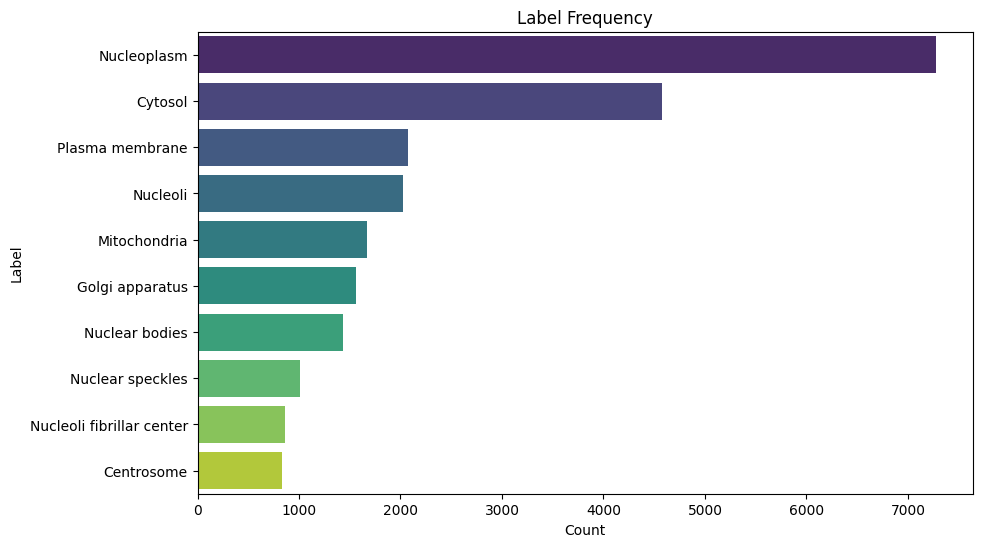

In [9]:
plot_label_count(df)

### 1.5 Stratified Cross Validation

To deal with rare case of classes and different combination of calsses, the data should be split eqaully into train set and validation set.

If not, model would have problem to predict rare class which is rarely present in train set.

But if we only use some portion (i.e. 80% if k=5) of data to train the model, model cannot learn from all of the datasets.

In other words, model should predict without learning some protion of data sets.

To solve those problems, stratified cross validation was adapted for this project.

*IterativeStratification* provides not only the function of split data into the number of folds with stratified, but also balanced representation with respect to order-th label combination (Sechidis et al., 2011).


In [13]:
def create_split_indices(df_dir, nfolds=args.nfolds, order=args.order):

    split_df = pd.read_csv(df_dir)
    split_df.set_index('Image', inplace=True)
    split_df = pd.get_dummies(split_df.Label.str.split(" ").explode()).groupby(level=0).sum()

    X, y = split_df.index.values, split_df.values

    k_fold = IterativeStratification(n_splits=nfolds, order=order)

    splits = list(k_fold.split(X, y))

    train_msk = {}
    val_msk = {}

    for i in range(nfolds):

        train_idx, val_idx = splits[i]

        train_msk[i] = split_df.iloc[train_idx].index.tolist()
        val_msk[i] = split_df.iloc[val_idx].index.tolist()

    return train_msk, val_msk

# Generate mask of train and validation set
train_msk, val_msk = create_split_indices(train_csv_dir)

#### 1.5.1 Count labels

Check whether data is equally split into train and validation sets.

In [11]:
df_CV = df.copy()
train_CV1 = df_CV[df_CV['Image'].isin(train_msk[1])].reset_index(drop=True)
val_CV1 = df_CV[df_CV['Image'].isin(val_msk[1])].reset_index(drop=True)

Nucleoplasm                  5819
Cytosol                      3659
Plasma membrane              1657
Nucleoli                     1620
Mitochondria                 1333
Golgi apparatus              1248
Nuclear bodies               1144
Nuclear speckles              805
Nucleoli fibrillar center     687
Centrosome                    669
Name: Label, dtype: int64


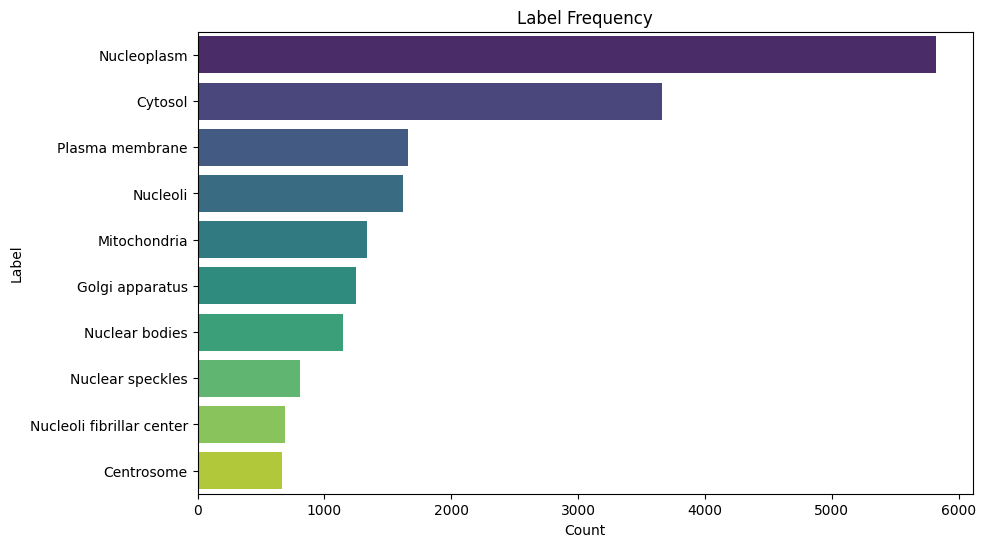

In [12]:
# Similar trend with original data
plot_label_count(train_CV1)

Nucleoplasm                  1454
Cytosol                       915
Plasma membrane               414
Nucleoli                      405
Mitochondria                  333
Golgi apparatus               312
Nuclear bodies                286
Nuclear speckles              202
Nucleoli fibrillar center     172
Centrosome                    167
Name: Label, dtype: int64


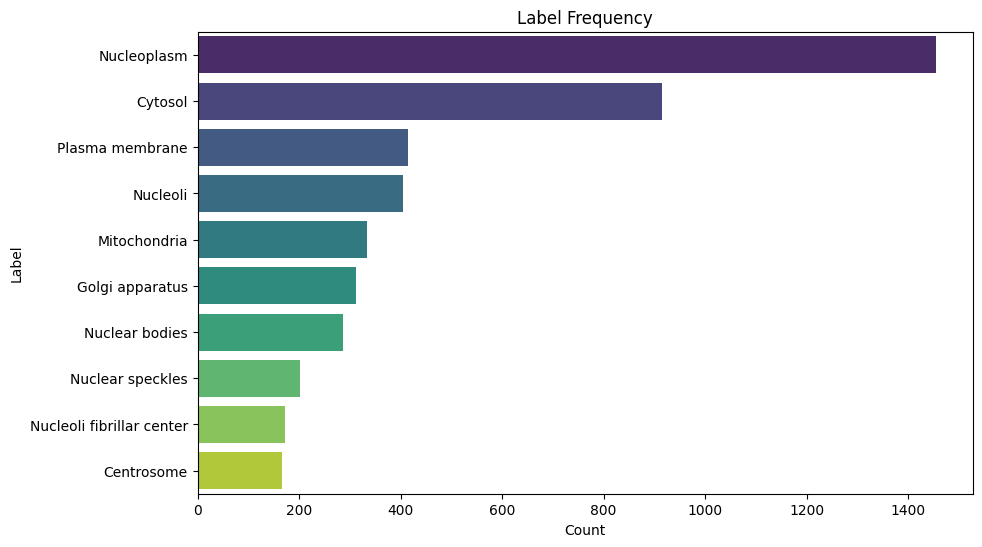

In [13]:
# Similar trend with original data
plot_label_count(val_CV1)

## 2 Data Augmentation

To prevent overfitting of the deep learning models, data augmentation strategy can be applied.

By artificailly modify the original image, model can learn more variation of images.

As a result, this technique can imporve the model performace by making the model have ability to deal with new image.

### 2.1 Torch Dataset

To make raw images be readable by model as tenosrs and encoded labels.

In [14]:
class ProteinDataset(Dataset):
    def __init__(self, df, root_dir, img_size, transform=None, is_test=False):
        self.df = df
        self.root_dir = root_dir
        self.is_test = is_test
        self.transforms = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.loc[idx]
        img_id = row["Image"]
        img_fname = self.root_dir + os.sep + str(img_id) + ".png"

        img = Image.open(img_fname)
        img = img.resize(self.img_size, resample=3)
        img = self.transforms(img)

        # For prediction
        if self.is_test:
            return img, img_id

        return img, encode_label(row["Label"])

### 2.2 Image Loader

In [15]:
def show_sample(img,target): 

    plt.imshow(img.permute(1,2,0)) #(C, H, W) --> (H, W, C)
    print('Label: ', decode_target(target, text_labels= True))

# Show orginal images and its transformation
def show_difference(img1, target1, img2, target2):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
    ax1.set_title('Before Transformation')
    ax2.set_title('After Transformation')

    ax1.imshow(img1.permute((1, 2, 0)))
    ax2.imshow(img2.permute((1, 2, 0)))

### 2.3 Normalization

Transform the image to tensors to normalize it in range of 0 to 1.

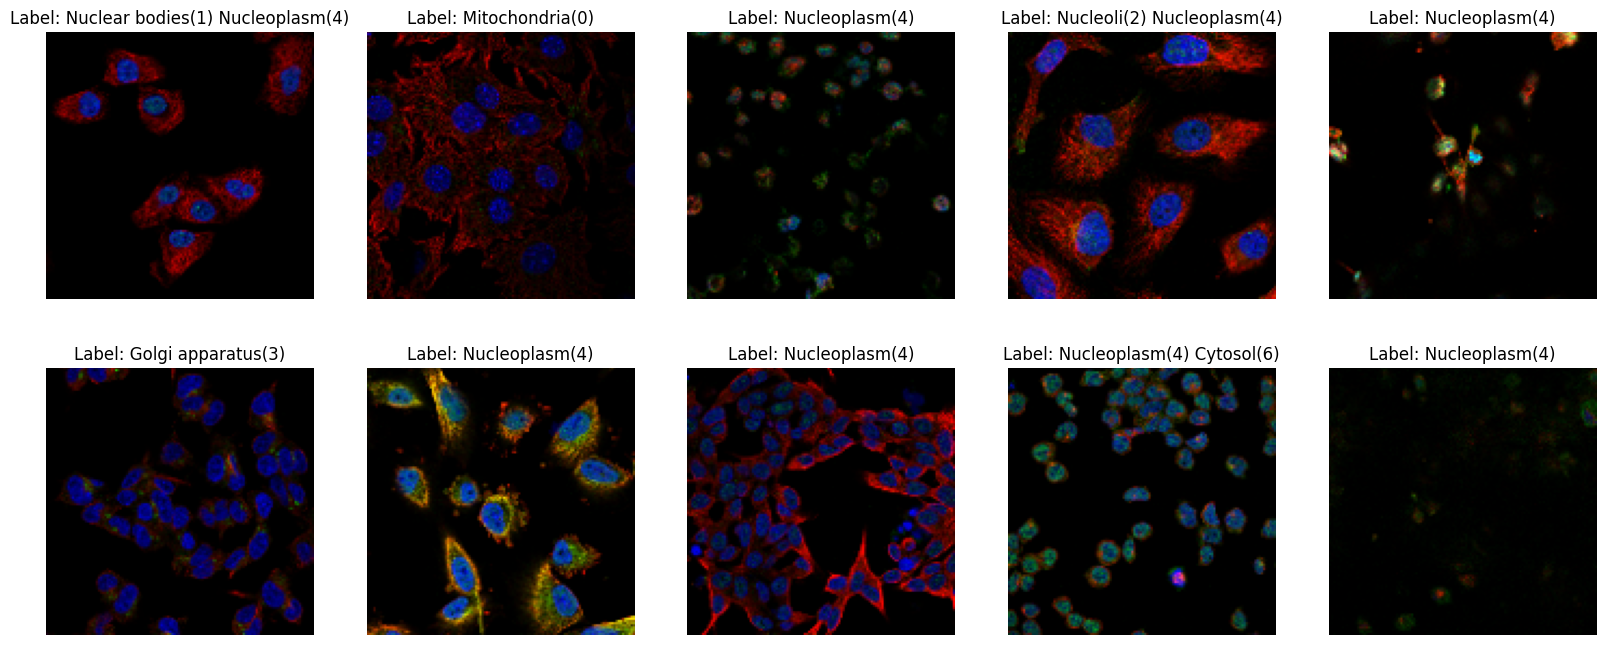

In [69]:
transforms_toTensor = tf.Compose([tf.ToTensor()])
dataset = ProteinDataset(df, args.train_data_dir, (124,124), transform=transforms_toTensor)

fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 10 sub plots
label_list = []

for i in range(10):
    img, target = dataset[i]  # i-th image and traget

    row = i // 5  
    col = i % 5   

    axs[row, col].imshow(img.permute(1, 2, 0))  # (C, H, W) --> (H, W, C)
    axs[row, col].set_title('Label: ' + decode_target(target, text_labels=True))
    axs[row, col].axis('off')  # remove axis

plt.show()

### 2.4 ImageNet Statistics

IamgeNet alreay made statistics using their millions of images.

The mean value is 0.485, 0.456, and 0.406 for each RGB channel.

The standard deviation value is 0.229, 0.224, and 0.225 for each RGB channel.

Since I use pre-trained model with this imageNet stats, it is better to use these values for training.

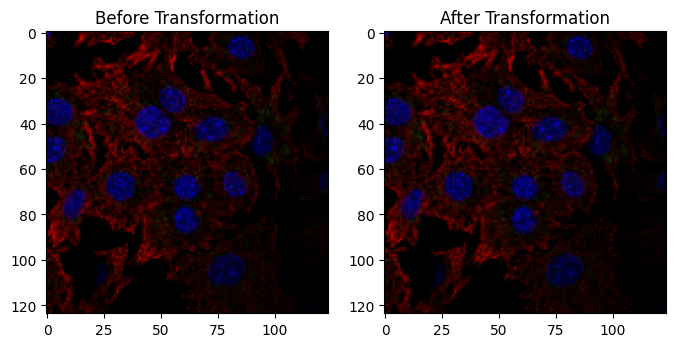

In [20]:
transforms_norm = tf.Compose([tf.ToTensor(),tf.Normalize(args.imageNet_mean, args.imageNet_std, inplace=True)])
dataset_norm = ProteinDataset(df, args.train_data_dir, (124,124), transform=transforms_toTensor)
show_difference(*dataset[1],*dataset_norm[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


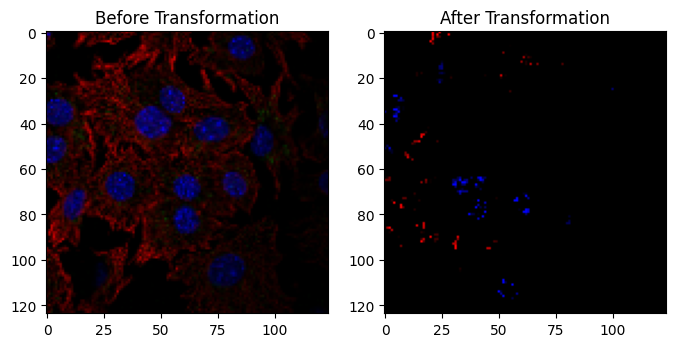

In [21]:
transforms_train = tf.Compose([tf.RandomAffine(
                                            degrees=40,  # Rotate images randomly to 40 degrees
                                            translate=(0.01, 0.12), # Move images randomly to vertically or horizontically from 1% to 12%
                                            shear=0.05,), # Tilt images randomly to 5%
                                            tf.RandomHorizontalFlip(), # 50% random horizontal flip
                                            tf.RandomVerticalFlip(), # 50% random vertical flip
                                            tf.ToTensor(), # Normalize to range of 0 ~ 1
                                            tf.Normalize(args.imageNet_mean, args.imageNet_std, inplace=True), # imageNet stat
                                            tf.RandomErasing(inplace=True),]
                                            )

dataset_fin = ProteinDataset(df, args.train_data_dir, (124,124), transform=transforms_train)
show_difference(*dataset[1],*dataset_fin[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


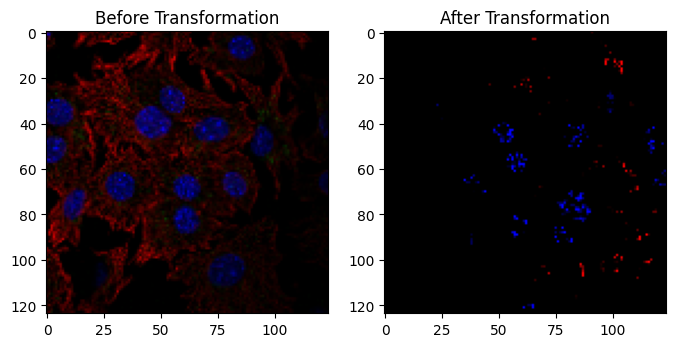

In [22]:
# data is transformed randomly
show_difference(*dataset[1],*dataset_fin[1])

### 2.5 Merge into DataModule

To easily load the data, merge data load function.

Data can be set up and loaded with this class.

In [23]:
class DataModule(pl.LightningDataModule):
    def __init__(self,
            df,
            test_df,
            train_msk,
            val_msk,
            batch_size=64,
            num_classes=10,
            resize=(384, 384),
            num_workers=4,
            is_test=None,
        ):
        super().__init__()

        self.df = df
        self.test_df = test_df
        self.train_msk = train_msk
        self.val_msk = val_msk
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.resize = resize
        self.num_workers = num_workers
        self.is_test = is_test

        # Transformation for augmentation
        self.transforms_train = tf.Compose([tf.RandomAffine(
                                                    degrees=40,
                                                    translate=(0.01, 0.12),
                                                    shear=0.05,),
                                                    tf.RandomHorizontalFlip(),
                                                    tf.RandomVerticalFlip(),
                                                    tf.ToTensor(),
                                                    tf.Normalize(args.imageNet_mean, args.imageNet_std, inplace=True),
                                                    tf.RandomErasing(inplace=True),]
                                                    )

        # Only normalize for validation
        self.transforms_valid = tf.Compose([tf.ToTensor(),
                                            tf.Normalize(args.imageNet_mean, args.imageNet_std, inplace=True)],
                                            )

        # Only normalize for prediction
        self.transforms_test = self.transforms_valid

    def setup(self, stage=None):
        # Generate train and validation data using CV mask
        train_df = self.df[self.df['Image'].isin(self.train_msk)].reset_index(drop=True)
        val_df = self.df[self.df['Image'].isin(self.val_msk)].reset_index(drop=True)

        self.train_ds = ProteinDataset(train_df, args.train_data_dir, img_size=self.resize, transform=self.transforms_train)

        self.val_ds = ProteinDataset(val_df, args.train_data_dir, img_size=self.resize, transform=self.transforms_valid)

        self.test_ds = ProteinDataset(self.test_df, args.test_data_dir, img_size=self.resize,transform=self.transforms_test, is_test=self.is_test)

    # Data Loaser
    def train_dataloader(self):
        return DataLoader(self.train_ds, self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, self.batch_size*2, num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, shuffle=False, num_workers=self.num_workers, pin_memory=True)

## 3 Model

### 3.1 Loss Function

#### 3.2 Binary Cross Entropy with Logits Loss

Binary Cross Entropy is one of the most famous and generally used loss function for classification task.

It improves performance compared to the case of using BCE and sigmoid function separately by combining the operations into one layer.

Pytorch provides this loss function.


#### 3.3 Focal Loss with Label Smoothing

Focal loss is developed to deal with class imbalnce problem by applying modulating terms to Cross Entropy loss to focus on hard example (Lin et al., 2017).

Even though our data have calss imbalance problem, I tried to use this fucntion to address model calibration with following strategies not as a class imbalance solution (Mukhoti et al., 2020):

1. Regularization of loss function

2. Label Smoohting

will be discussed in model calibration section.

Since the focal loss provided pytorch makes loss value too small, the model had a problem to keep learning. 

This problem is caused by $\alpha$ and $\gamma$ values which makes loss of easier cases smaller.

So I used the equation of focal loss described by the original paper:

- FL(pt) = -α<sub>t</sub>(1 - p<sub>t</sub>)<sup>γ</sup> log(p<sub>t</sub>)


In [24]:
def sigmoid_focal_loss(out, targets, alpha=1, gamma=2, reduction='mean'):
    bce_loss = F.binary_cross_entropy_with_logits(out, targets, reduction='none')

    # Prevents nans when probability 0
    pt = torch.exp(-bce_loss)

    F_loss = alpha * (1 - pt) ** gamma * bce_loss

    # Reduction of the result
    if reduction == "mean":
        return torch.mean(F_loss)
    elif reduction == "sum":
        return torch.sum(F_loss)
    else:
        return F_loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0, reduction='mean', label_smoothing = 0.1):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Smoothing the label
        if self.label_smoothing:
            targets = targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        else:
            pass

        focal_loss = sigmoid_focal_loss(
            inputs,
            targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )

        return focal_loss

### 3.3 Efficient Net V2

EfficientNet V2 is developed version of original EfficientNet (Tan & Le, 2021).

This model structure has an advantage of the number of parameters to train.

It is generally smaller and more computationally efficient compared other models such as ResNet or Vision Transformer (VIT),

As a result, this model is not so heavy, but enough performace ability.

In [25]:
class Model_summary(pl.LightningModule):
    def __init__(self,
            model_name :str ='efficientnet_v2_s',
            class_num : int=10,
            ):
        super().__init__()
        
        self.model = getattr(models, model_name)(weights="DEFAULT")
        num_feat = self.model.classifier[1].in_features 

        self.model.classifier = nn.Sequential(
            nn.Linear(num_feat, class_num))
        

model_summary = Model_summary(model_name=args.model_name,
              class_num = args.num_classes)

summary(model_summary,
    device="cpu", 
    col_names=["num_params", "trainable"])

Layer (type:depth-idx)                                       Param #                   Trainable
Model_summary                                                --                        True
├─EfficientNet: 1-1                                          --                        True
│    └─Sequential: 2-1                                       --                        True
│    │    └─Conv2dNormActivation: 3-1                        696                       True
│    │    └─Sequential: 3-2                                  10,464                    True
│    │    └─Sequential: 3-3                                  303,552                   True
│    │    └─Sequential: 3-4                                  589,184                   True
│    │    └─Sequential: 3-5                                  917,680                   True
│    │    └─Sequential: 3-6                                  3,463,840                 True
│    │    └─Sequential: 3-7                                  14,561,832    

### 3.4 Freeze Backbone

Freeze backbone to speed up of training, but there was tidious speedup with decrease of F1 score, it was not adopted for this project.

### 3.5 Macro F1 Score

Particulary used for imbalanced class data.

It gives different weight to every individual decision.

### 3.6 Adam optimizer

Popular for training neural networks due to its efficiency and effectiveness in handling sparse gradients and adapting the learning rate for each parameter.

Weight decay is applied to prevent overfitting by adding regularization term to loss function.

### 3.7 Pytorch Lightning

Since using pytorch lightning which makes user make deep learning model easir by get rid of some for loops and providing useful functions like callbacks.

So there was no need to things like set the device, but the result of calibration list was needed to be detached.

In [26]:
class Model(pl.LightningModule):
    def __init__(self,
            model_name :str ='efficientnet_v2_s',
            class_num : int=10,
            learning_rate: float=1e-4,
            threshold : float=0.4,
            freeze: str='freeze',
            unfreeze_point: int=5,
            weight_decay: float=1e-4,
            scheduler: str='MultiStepLR',
            lossfn: str='BCE',
            only_fc: str='FcFreeze',
            alpha: float = 1.0,
            gamma: int = 0,
            reduction: str = 'mean',
            label_smoothing:float = 0.0,
        ):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        
        # Load model from torch vision models
        self.model = getattr(models, model_name)(weights="DEFAULT")
        self.sigmoid = torch.nn.Sigmoid()

        # For model calibration
        self.calibration_pred = []
        self.calibration_label = []

        num_feat = self.model.classifier[1].in_features # Efficientnet

        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_feat, class_num))

        #num_feat = self.model.heads[-1].in_features # Vit
        #self.model.heads[-1] = nn.Sequential(
        #    torch.nn.Linear(num_feat, class_num))

        #num_feat = self.model.fc.in_features # Resnet
        #self.model.fc = nn.Sequential(
        #    nn.Linear(num_feat, class_num))

        if self.hparams.lossfn == 'BCE':
          self.loss_fn = nn.BCEWithLogitsLoss()
        else:
          self.loss_fn = FocalLoss(alpha = self.hparams.alpha,
                                  gamma = self.hparams.gamma,
                                  reduction = self.hparams.reduction,
                                  label_smoothing = self.hparams.label_smoothing,
                                  )

        # Mean of all batch in one epoch
        self.mean_train_loss = MeanMetric()
        self.mean_train_f1   = MultilabelF1Score(num_labels=self.hparams.class_num,
                                                 average="macro", threshold=self.hparams.threshold)
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_f1   = MultilabelF1Score(num_labels=self.hparams.class_num,
                                                 average="macro", threshold=self.hparams.threshold)

        # Take a look for model sensitiviy and specificity for threshold adjustment
        self.mean_auc_roc = MultilabelAUROC(num_labels=self.hparams.class_num, average="macro")


    # will be used during inference
    def forward(self, x):
       return self.model(x)
       #return torch.sigmoid(self.model(x))

    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.require_grad = False
        for param in self.model.classifier.parameters():
            param.require_grad = True

    def unfreeze(self):
        # Unfreeze all layers
        if self.hparams.only_fc:
            for param in self.model.parameters():
                param.require_grad = True
        else:
            for i, child in enumerate(self.model.children()):
                if i > 6:
                    for param in child.parameters():
                        param.requires_grad = True


    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # training metrics
        self.mean_train_loss(loss, weight=x.shape[0])
        self.mean_train_f1(self.sigmoid(logits), y)

        return loss

    def on_train_epoch_start(self):
        if self.hparams.freeze:
            if self.current_epoch == self.hparams.unfreeze_point:
                self.unfreeze()
            elif self.current_epoch == 0:
                self.freeze()
        else:
            pass

    def on_train_epoch_end(self):
        # Computing and logging the training mean loss & mean f1.
        self.log("train-loss", self.mean_train_loss, prog_bar=True)
        self.log("train-f1",   self.mean_train_f1,   prog_bar=True)
        self.log("epoch", self.current_epoch)

    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # validation metrics
        self.mean_valid_loss(loss, weight=x.shape[0])
        self.mean_valid_f1(self.sigmoid(logits), y)
        self.mean_auc_roc(self.sigmoid(logits), y.int())

    def on_validation_epoch_end(self):
        # Computing and logging the validation mean loss & mean f1.
        self.log("valid-loss", self.mean_valid_loss, prog_bar=True)
        self.log("valid-f1",   self.mean_valid_f1,   prog_bar=True)
        self.log("AUC_ROC",   self.mean_auc_roc,   prog_bar=True)
        self.log("epoch", self.current_epoch)

    def test_step(self, batch):
        x, y = batch
        logits = self(x)

        # Save validation set results
        for pred in self.sigmoid(logits):
          self.calibration_pred.append(pred)
        for label in y:
          self.calibration_label.append(label)

    def predict_step(self, batch):
        x , id = batch
        logits = self(x)

        return self.sigmoid(logits)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                    lr=self.hparams.learning_rate,
                    weight_decay=self.hparams.weight_decay
                    )

        if self.hparams.scheduler == 'MultiStepLR':
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                                milestones=[self.trainer.max_epochs // 3],
                                                                gamma=0.1,
                                                                )

            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}

        elif self.hparams.scheduler == 'CosineAnnealingLR':
            lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                                T_max=self.trainer.max_epochs,
                                                                eta_min=0,
                                                                last_epoch=-1,
                                                                verbose=False,
                                                                )

            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}

        else:
            return optimizer

## 4 Training & Inference

### 4.1 Training Phase

Using 5-fold CV datasets, model is trained 5 times and validated by unseen validation data.

### 4.2 Callback Functions

Pytorch Lightning provides various callback functions make it easier to use.

-  **Learning Rate Monitor**

    Since I used CosineAnnealing accurate epoch can be displayed via lr monitor

-  **Early Stopping**

    If model reached the overfitting point where validation loss increase while train loss decreases, training is automatically stopped based on patience.

    - Patience: After n-th steps, if validation loss becomses no longer better training is stopped.
    
*  **Check Point**

    By saving best model based on highest validation F1 score, I can use best model for inference phase.

-  **Wandb Logger**

    I can easily upload my running logs using Wandb, so I can look after whenever I want.

    With this result I could make a dicision what model to use.

### 4.3 Threshold setting

Threshold value is set based on F1 score of validation set and Kaggle score.

AUC-ROC cureve was drawn but it was not much considered for this project.

In [20]:
# Set the group name of 5 cross validation
#exp_name = f"{args.model_name}-Thre:{args.threshold}-ImgSize{args.image_size}-using-{args.scheduler}-With-{args.lr}" # for Google Colab
exp_name = 'CosineBCE'

for i in range(args.nfolds):
  wandb_logger = WandbLogger(project='Project2', entity='jilim97', name=f"CV{i+1}", group=exp_name ) # with exp name as group and each CV saved named CV-n
  lr_monitor = LearningRateMonitor(logging_interval='epoch') # To look change of learning rate

  # Save the best model based on F1 score with corresponding epoch, score and CV number
  checkpoint_callback = ModelCheckpoint(
    dirpath= exp_name + os.sep,
    filename= 'checkpoint-{epoch:02d}-{valid-f1:.2f}' + f'_CV{i+1}',
    save_top_k=1,
    monitor='valid-f1',
    mode='max',
  )

  # To stop training if there seems overfitting
  early_stop_callback = EarlyStopping(
    monitor='valid-loss',
    min_delta=0.00,
    patience=args.patience,
    verbose=False,
    mode='min'
  )

  # Model parameter setting
  model = Model(
      model_name = args.model_name,
      class_num = args.num_classes,
      learning_rate = args.lr,
      threshold = args.threshold,
      freeze = args.freeze,
      unfreeze_point = args.unfreeze_point,
      scheduler = args.scheduler,
      lossfn = args.lossfn,
      weight_decay = args.weight_decay,
      only_fc = args.only_fc,
      alpha = args.alpha,
      gamma = args.gamma,
      reduction = args.reduction,
      label_smoothing = args.label_smoothing,
  )


  data_module = DataModule(
      df = df,
      test_df = test_df,
      train_msk = train_msk[i],
      val_msk = val_msk[i],
      num_classes=args.num_classes,
      resize=args.image_size,
      batch_size=args.batch_size,
      num_workers = args.num_workers,
  )
  
  # Split Train & Val data
  data_module.setup()

  # Initialize a trainer
  trainer = pl.Trainer(max_epochs=args.num_epochs,
                      devices="auto",
                      precision="16-mixed",  # speed up training and rduce memory
                      callbacks=[checkpoint_callback,
                                 lr_monitor,
                                 ],
                      logger=wandb_logger)


  # Train the model
  trainer.fit(model, data_module)

  wandb.finish()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 155MB/s]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type              | Params
------------------------------------------------------
0 | model           | EfficientNet      | 20.2 M
1 | sigmoid         | Sigmoid           | 0     
2 | loss_fn         | BCEWithLogitsLoss | 0     
3 | mean_train_loss | MeanMetric        | 0     
4 | mean_train_f1   | MultilabelF1Score | 0     
5 | mean_valid_loss | MeanMetric        | 0     
6 | mean_valid_f1   | MultilabelF1Score | 0     
7 | mean_auc_roc    | MultilabelAUROC   | 0     
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.761    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: jilim97. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/efficientnet_v2_s-Thre:0.3-ImgSize(384, 384)-using-CosineAnnealingLR-With-0.0005 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type              | Params
------------------------------------------------------
0 | model           | EfficientNet      | 20.2 M
1 | sigmoid         | Sigmoid           | 0     
2 | loss_fn         | BCEWithLogitsLoss | 0     
3 | mean_train_loss | MeanMetric        | 0     
4 | mean_train_f1   | MultilabelF1Score | 0     
5 | mean_valid_loss | MeanMetric        | 0     
6 | mean_valid_f1   | MultilabelF1Score | 0     
7 | mean_auc_roc    | MultilabelAUROC   | 0     
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.761  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type              | Params
------------------------------------------------------
0 | model           | EfficientNet      | 20.2 M
1 | sigmoid         | Sigmoid           | 0     
2 | loss_fn         | BCEWithLogitsLoss | 0     
3 | mean_train_loss | MeanMetric        | 0     
4 | mean_train_f1   | MultilabelF1Score | 0     
5 | mean_valid_loss | MeanMetric        | 0     
6 | mean_valid_f1   | MultilabelF1Score | 0     
7 | mean_auc_roc    | MultilabelAUROC   | 0     
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.761    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type              | Params
------------------------------------------------------
0 | model           | EfficientNet      | 20.2 M
1 | sigmoid         | Sigmoid           | 0     
2 | loss_fn         | BCEWithLogitsLoss | 0     
3 | mean_train_loss | MeanMetric        | 0     
4 | mean_train_f1   | MultilabelF1Score | 0     
5 | mean_valid_loss | MeanMetric        | 0     
6 | mean_valid_f1   | MultilabelF1Score | 0     
7 | mean_auc_roc    | MultilabelAUROC   | 0     
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.761    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type              | Params
------------------------------------------------------
0 | model           | EfficientNet      | 20.2 M
1 | sigmoid         | Sigmoid           | 0     
2 | loss_fn         | BCEWithLogitsLoss | 0     
3 | mean_train_loss | MeanMetric        | 0     
4 | mean_train_f1   | MultilabelF1Score | 0     
5 | mean_valid_loss | MeanMetric        | 0     
6 | mean_valid_f1   | MultilabelF1Score | 0     
7 | mean_auc_roc    | MultilabelAUROC   | 0     
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.761    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


### 5.2 Model Selection

Based on Kaggle score and validation F1 score, best model (EfficientNet with BCE loss using CosineAnnealing scheduler).

Before apporaoching the point of overfitting where validation loss value starts to increase, more epoch numbers can improve model performance.

Surely, threre is a limitation with only using epochs for imprving strategy, but it is obvious enough epoch numbers with appropriate learning rate helps improve model performace.

Adjusting learning rate is also important, so it should be optimized through trial & error depends on loss function or model type.

Many strateigies for this project is following pytorch experiment report by Vryniotis (2021).

For focal loss, fine tuinong of learning rate was required to trian model.

So using Cosine Annealing scheduler showed better performance than using MultiStep learning rate scheduler for focal loss.

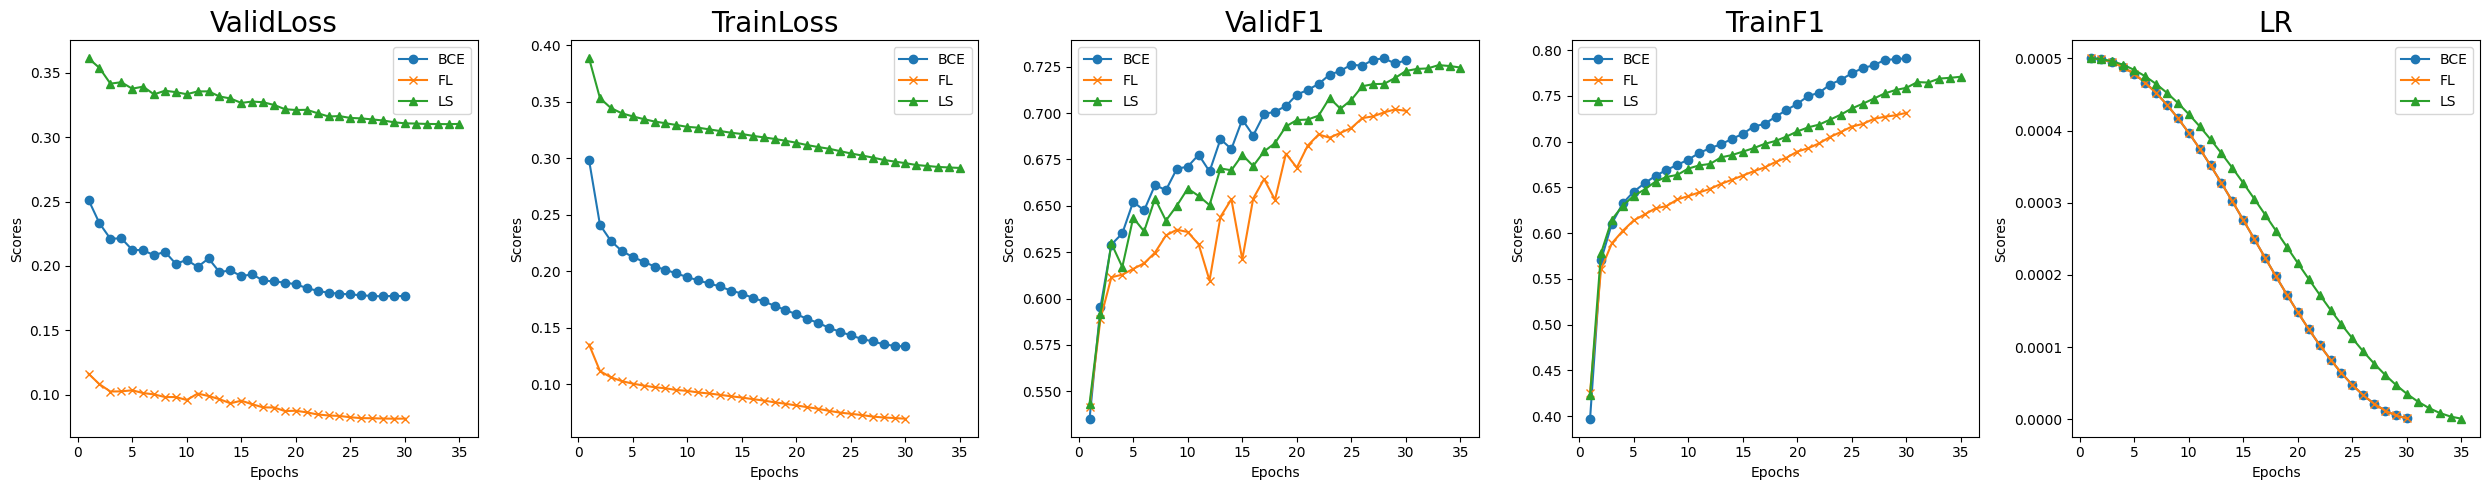

In [27]:
csv_files = ['ValidLoss.csv', 'TrainLoss.csv', 'ValidF1.csv', 'TrainF1.csv', 'LR.csv']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
 
# Plot each model log 
for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file)

    axes[i].plot(df['epochs'], df['BCE'], label='BCE', marker='o') # BCE loss with cosine annealing
    axes[i].plot(df['epochs'], df['FL'], label='FL', marker='x') # Focal loss with cosine annealing
    axes[i].plot(df['epochs'], df['LS'], label='LS', marker='^') # Label smoohing BCE with cosine annealing

    # Title and labels
    axes[i].set_title(csv_files[i][:-4], fontsize=20)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Scores')
    axes[i].legend()

plt.tight_layout()
plt.show()

### 4.3 Inference Phase

Load the best model during epochs based on validation F1 score, and predict with the models.

-   **BCE using MultiStep**

    - **Kaggle score: 0.77166**

    - Highest average (5-CV) Valid F1 score: 0.72674

-   **BCE using CosineAnnealing**

    - Kaggle score: 0.76769

    - **Highest average (5-CV) Valid F1 score: 0.72950**

-   BCE with label smoothing (0.1) using CosineAnnealing

    - Kaggle score: 0.74425

    - Highest average (5-CV) Valid F1 score: 0.72584

-   Focal Loss ($\alpha$ = 0.9 and $\gamma$ = 1 )using CosineAnnealing

    - Kaggle score: 0.72176

    - Highest average (5-CV) Valid F1 score: 0.70194
 
Since ther are 5 different validation sets in 5-fold CV datasets, I merged all different 5 validation datasets into 1 to assess Expected Calibration Eerror (ECE) of model.

As a result, all of the datasets (about 15000 images) could be used for accesing ECE.

Kaggle score was higher with using noraml BCE loss with MultiStep scheduler than using normal BCE loss with CosineAnnealing scheduler.

The highest average valid f1 score among 5-fold datasets of BCE with CosineAnnealing was slghtly higher.

But to compare the effect of calibration method, BCE with CosineAnnealing was adopted for this project.

To make it easy to load, file name is set different as original directory (CKPT_PATH).

In [21]:
#CKPT_PATH = exp_name + os.sep # set directory to make prediction and checkpoint , for Google Colab
CKPT_PATH = 'CosineBCE/'

predictions = []
val_pred = []
val_label = []

for filename in os.listdir(CKPT_PATH):
  if '.ckpt' in filename: # to preent load of unnecessry file
    print(filename)
    model = Model.load_from_checkpoint(CKPT_PATH + filename)

    # Initialize trainer as inference mode
    trainer = pl.Trainer(
        accelerator="auto",
        devices='auto',
        enable_checkpointing=False,
        inference_mode=True,
    )

    # Load appropriate n-th CV validation data
    i = int(filename[-6]) - 1

    data_module = DataModule(
        df = df,
        test_df = test_df,
        train_msk = train_msk[i],
        val_msk = val_msk[i],
        num_classes=args.num_classes,
        resize=args.image_size,
        batch_size=args.batch_size,
        num_workers = args.num_workers,
        is_test = args.is_test,
    )

    # Split Train & Val data
    data_module.setup()
    
    # Re-run with validation data using best model to make a calibration curve (unseen data during training)
    valid_loader = data_module.val_dataloader()
    trainer.test(model=model, dataloaders=valid_loader)

    # Make a whole list of calibration rsult
    val_pred += model.calibration_pred

    val_label += model.calibration_label

    #Submission
    test_loader = data_module.test_dataloader()

    prediction = trainer.predict(model=model, dataloaders=test_loader)

    # Make a whole list of all 5 preicitons
    predictions.append(prediction)

checkpoint-epoch=26-valid-f1=0.74_CV5.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

checkpoint-epoch=27-valid-f1=0.73_CV4.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

checkpoint-epoch=24-valid-f1=0.72_CV1.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

checkpoint-epoch=24-valid-f1=0.73_CV3.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

checkpoint-epoch=29-valid-f1=0.73_CV2.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

## 5 Model Calibration

To deal with uncertainty of the model, Expected Calibration Error (ECE) was assessed for this project.

There are two ECE methods are used:

- Binary ECE

    - Calculate the ECE class by calss considering only predicted probabilities by deep learning model

    - By averaging of all 10 calssses, it becomes same with calsswise ECE value

    - **binary-ECE** = $\sum_{i=1}^M \frac{|B_{i}|}{N} | \bar{y}(B_{i}) - \bar{p}(B_{i}) |$


- Confidence ECE

    - Calculate the ECE class by calss considering maximum probabilities predicted

    - **confidence-ECE** = $\sum_{i=1}^M \frac{|B_{i}|}{N} | \text{accuracy}(B_{i}) - \bar{p}(B_{i}) |$

In [14]:
label_file_BCE = 'CosineBCE/all_labels.pkl'

pred_file_BCE = 'CosineBCE/all_pred.pkl'

# Load the pickle files ran on Google Colab
with open(label_file_BCE, 'rb') as file:
    val_label_BCE = pickle.load(file)
    
with open(pred_file_BCE, 'rb') as file:
    val_pred_BCE = pickle.load(file)

### 5.1 Predicted result calss distribution

Before looking ECE, I made a distribution of classes and it is quite similar to original one.

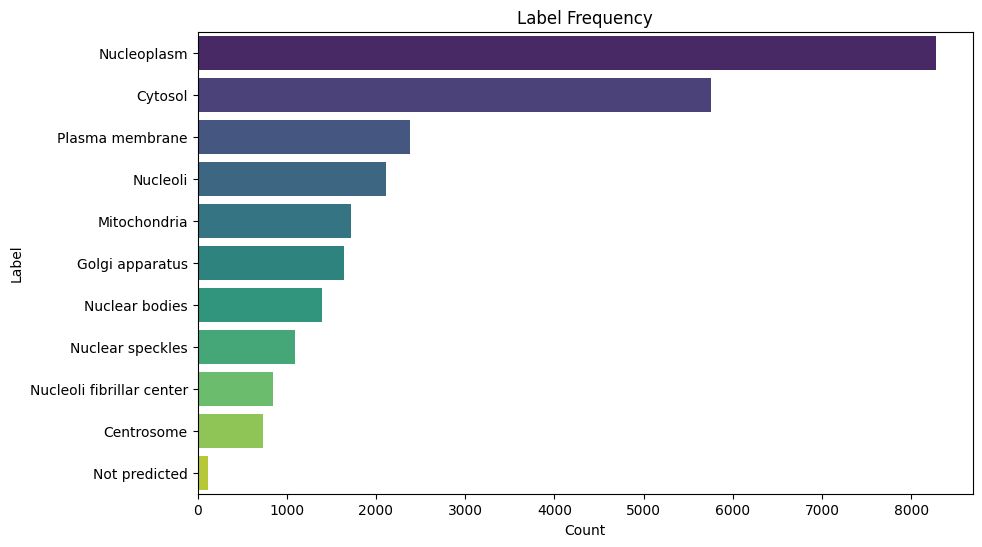

In [60]:
#val_pred_BCE = torch.stack(val_pred).cpu().numpy() # Detach from GPU
#val_label_BCE = torch.stack(val_label).cpu().numpy()

# Since not predicted result exists, make a new dict str version
label_dict_str = {'0': 'Mitochondria',
                '1': 'Nuclear bodies',
                '2': 'Nucleoli',
                '3': 'Golgi apparatus',
                '4': 'Nucleoplasm',
                '5': 'Nucleoli fibrillar center',
                '6': 'Cytosol',
                '7': 'Plasma membrane',
                '8': 'Centrosome',
                '9': 'Nuclear speckles',
                '': 'Not predicted'}

val_df = pd.DataFrame({'Image': range(1, len(val_pred_BCE) + 1)})

pred_dict = {id: (pred > args.threshold).nonzero()[0] for id, pred in zip(val_df['Image'], val_pred_BCE)}

df_no_brackets = pd.DataFrame([
    [id, ' '.join(map(str, labels))] for id, labels in pred_dict.items()
], columns=['Image', 'Label'])

# Label frequency
label_df = df_no_brackets.assign(Label=df_no_brackets['Label'].str.split(" ")).explode('Label')
label_counts = label_df['Label'].value_counts()
label_counts = label_counts.rename(index=label_dict_str)

# Plot
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Label', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Label', data=label_counts_df, palette='viridis')
plt.title('Label Frequency')
plt.show()


### 5.2 Expected Calibration Error  of Model

Following contents are ECE value of my depp learning model with calibraion curve.

Without any additional precessing, model looks like quite well calibrated.

Dropout could be a potential factor as it randomly filters some predictions to prevent overfitting.

As illustrated below, the two classes with the highest ECE values are 'Nucleoplasm' and 'Cytosol,' which also happen to be the two most frequently occurring labels in the dataset. 

The high frequency of these samples leads to more of them being binned during the ECE calculation, potentially causing the model to be biased towards these samples.

In other words, there could be possible to be overfit toward these samples, leading over or underconfidnt prediction.

But model is well enough calibrated to discuss about error.

AVG Binary ECE Score: 0.013986428286820946
AVG Conf ECE Score: 0.01257818624502162


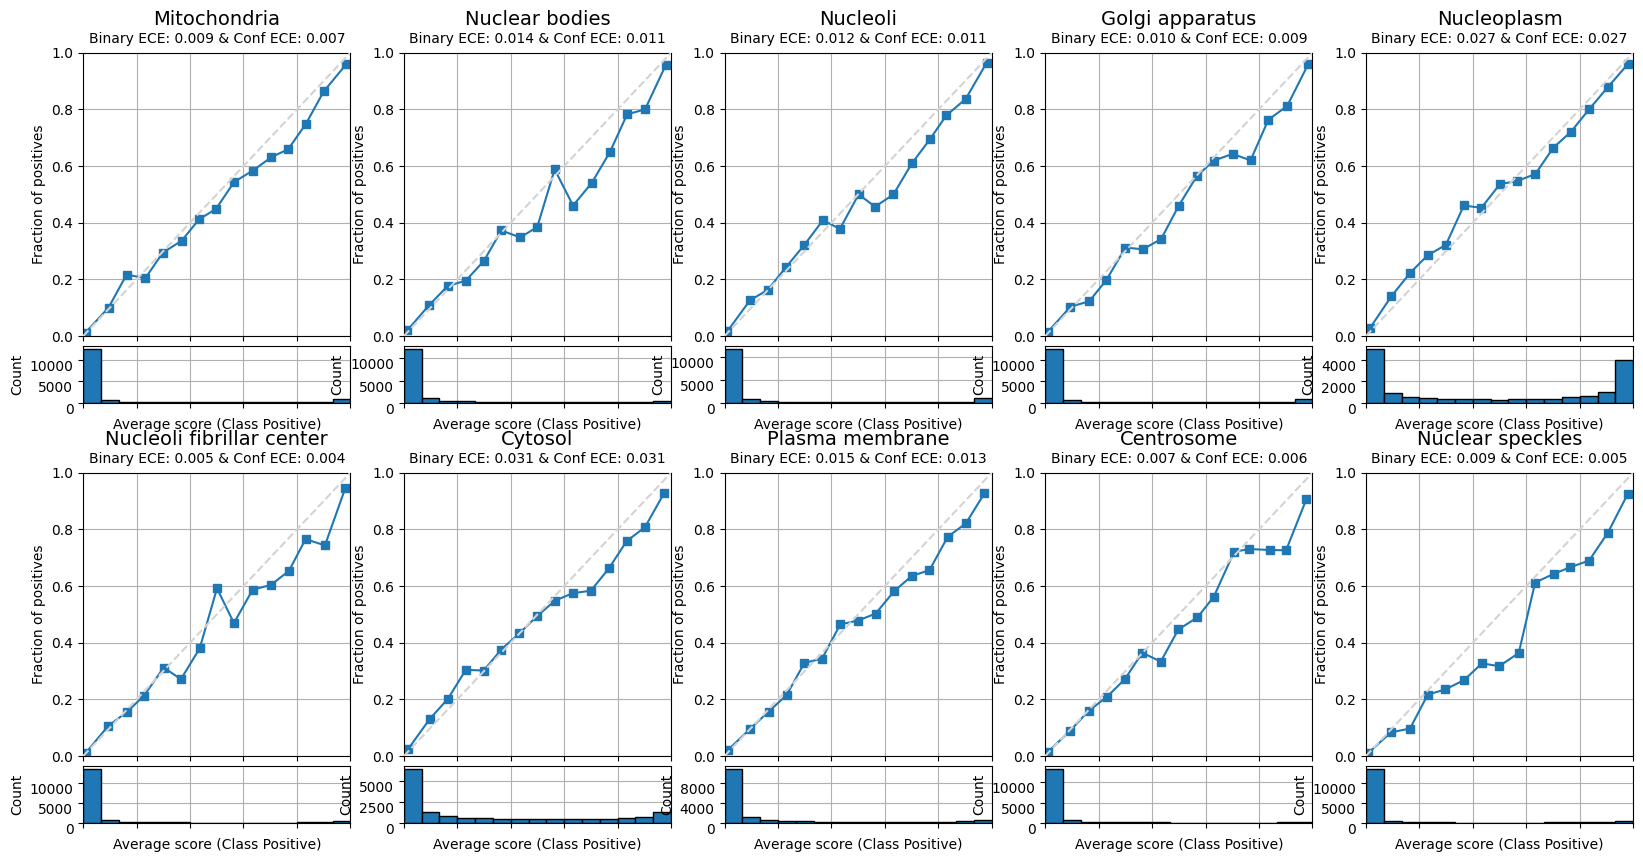

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [29]:
Binary_ECE_avg = 0
Conf_ECE_avg = 0

fig, axes = plt.subplots(2, 5, figsize=(20, 10)) 

for i in range(args.num_classes):
  # Transpose the data to separate per claases
  p_pred = np.vstack((1-val_pred_BCE.T[i],val_pred_BCE.T[i])).T
  pred = val_pred_BCE.T[i]
  y_train = val_label_BCE.T[i]
  
  Binary_ECE_score = binary_ECE(y_train, pred, bins=args.nbins)
  Binary_ECE_avg += Binary_ECE_score
  
  Conf_ECE_score = conf_ECE(y_train, p_pred, bins=args.nbins)
  Conf_ECE_avg += Conf_ECE_score
  

  ax = axes[i // 5, i % 5]
  # Main title (Class name)
  ax.set_title(labels_dict[i], fontsize=14, pad=20) 
  # sub title (ECE score)
  ax.text(0.5, 1.05, f"Binary ECE: {Binary_ECE_score:.3f} & Conf ECE: {Conf_ECE_score:.3f}", 
        ha='center', va='center', fontsize=10, transform=ax.transAxes)

  plot_reliability_diagram(y_train, scores=p_pred,
                          show_histogram=True,
                          bins=args.nbins,
                          class_names=['Negative', 'Positive'],
                          ax=ax)
  

print(f'AVG Binary ECE Score: {Binary_ECE_avg/10}') # Same with clasewise ECE
print(f'AVG Conf ECE Score: {Conf_ECE_avg/10}')

plt.tight_layout() 
plt.show()

### 5.3 Calibration Method

There are several strategies to well calibrate the model.

**1. Post-Training Calibration:**

This approach involves calibrating trained model to reduce calibration error typically using linear regression models like isotonic regrssion for calibration.

Isotonic regression could be applied for validdation result of my deep learning model, but no applied for this project. 

Instead 2nd strategy was applied.

**2. Calibration during training the model**

- Mix-up training

- **Regularizing network by penalizing confident output (Pereyra et al., 2017)**

- **Label smmothing (Müller, Kornblith, & Hinton, 2019).**

For my case, I used second and third methods to calibrate my model. 

Since our input images already contain multiple labels, this method might introduce confusion and hinder the model's ability to learn distinct features.

In this project, I focused on using the Focal loss function for regularization. 

Focal loss is effective as it penalizes outputs that are easily detectable, thereby encouraging the model to focus on more challenging cases.

For label smoothing, it was applied only in the loss calculation phase, not throughout the entire training process due to calculation of F1 score.

Label smoothing works by reducing the model's confidence in its predictions.

Overall, for my model calibration, I employed the regularizing network and label smoothing strategies. 

In [30]:
label_file_FL = 'CosineFL/all_labels.pkl'

pred_file_FL = 'CosineFL/all_pred.pkl'

# Load the pickle files ran on Google Colab
with open(label_file_FL, 'rb') as file:
    val_label_FL = pickle.load(file)
    
with open(pred_file_FL, 'rb') as file:
    val_pred_FL = pickle.load(file)

Binary_ECE_avg_FL = 0
Conf_ECE_avg_FL = 0

for i in range(args.num_classes):
  p_pred = np.vstack((1-val_pred_FL.T[i],val_pred_FL.T[i])).T
  pred = val_pred_FL.T[i]
  y_train = val_label_FL.T[i]
  
  Binary_ECE_score_FL = binary_ECE(y_train, pred, bins=args.nbins)
  Binary_ECE_avg_FL += Binary_ECE_score_FL
  
  Conf_ECE_score_FL = conf_ECE(y_train, p_pred, bins=args.nbins)
  Conf_ECE_avg_FL += Conf_ECE_score_FL


In [31]:
label_file_LS = 'CosineLS01/all_labels.pkl'

pred_file_LS = 'CosineLS01/all_pred.pkl'

# Load the pickle files ran on Google Colab
with open(label_file_LS, 'rb') as file:
    val_label_LS = pickle.load(file)
    
with open(pred_file_LS, 'rb') as file:
    val_pred_LS = pickle.load(file)

Binary_ECE_avg_LS = 0
Conf_ECE_avg_LS = 0

for i in range(args.num_classes):
  p_pred = np.vstack((1-val_pred_LS.T[i],val_pred_LS.T[i])).T
  pred = val_pred_LS.T[i]
  y_train = val_label_LS.T[i]
  
  Binary_ECE_score_LS = binary_ECE(y_train, pred, bins=args.nbins)
  Binary_ECE_avg_LS += Binary_ECE_score_LS
  
  Conf_ECE_score_LS = conf_ECE(y_train, p_pred, bins=args.nbins)
  Conf_ECE_avg_LS += Conf_ECE_score_LS


### 5.4 Result of Calibraion

The data below indicates that the ECE scores increased after applying calibration strategies.

**- Focal loss**

I guess that more optimization toward the loss function would be necessary.

The performance (F1 score) of model using focal loss is lowest among other results.

So it should be firstly well optimized before applying it a calibration strategy.

**- Label Smoothing**

One notable difference is in the reduction calculation squence between standard BCE and BCE with label smoothing.

To combine label smoothing and focal loss, reduction (mean calculation of loss) should be done after whole calculation of loss values.

Furthermore the proportion of each class wasn't considered for label smoothing (i.e. all 1 for 1-a, all 0 for a).

In summary, while the calibration strategies showed potential, they also highlighted the need for more nuanced adjustment.

Furthermore, since the original model was already well calibrated, these strategies might be a factor of hinderance of calibration.

AVG Binary ECE Score 
BCE: 0.0140 
FL: 0.0571 
LS: 0.0505

AVG Conf ECE Score 
BCE: 0.0126 
FL: 0.0564 
LS: 0.0501


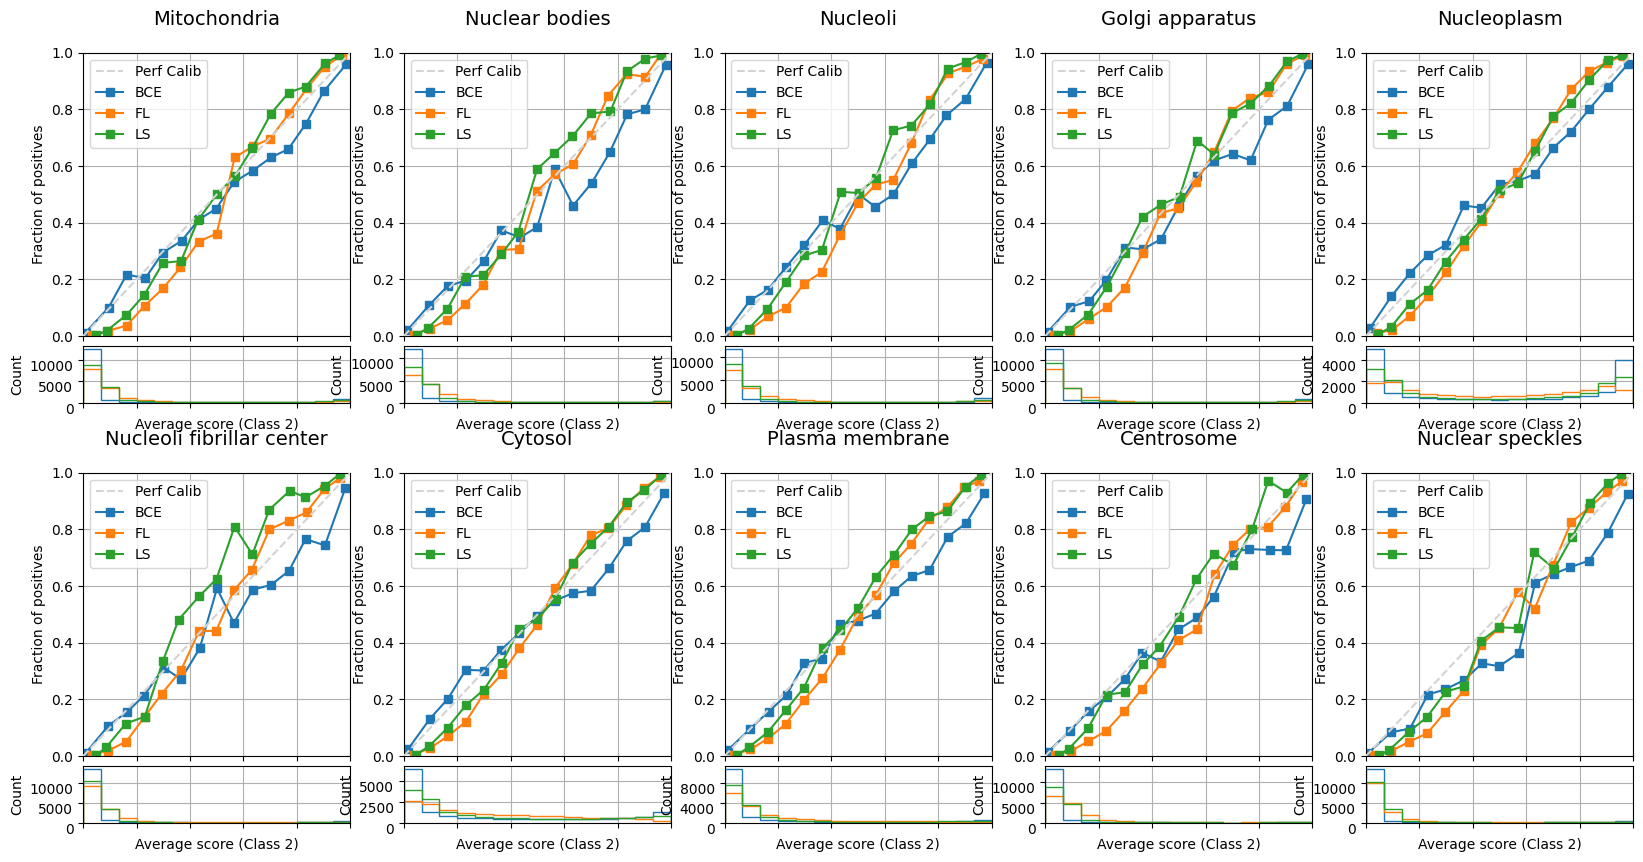

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # for subplot

for i in range(10):
  p_pred_BCE = np.vstack((1-val_pred_BCE.T[i],val_pred_BCE.T[i])).T
  p_pred_FL = np.vstack((1-val_pred_FL.T[i],val_pred_FL.T[i])).T
  p_pred_LS = np.vstack((1-val_pred_LS.T[i],val_pred_LS.T[i])).T

  y_train = val_label_BCE.T[i]
  
  # for subplot
  ax = axes[i // 5, i % 5]
  ax.set_title(labels_dict[i], fontsize=14, pad=20) 
  

  plot_reliability_diagram(y_train, scores=[p_pred_BCE,p_pred_FL,p_pred_LS],
                          show_histogram=True,
                          bins=args.nbins,
                          ax=ax)
  ax.legend(['Perf Calib','BCE', 'FL', 'LS'])

print(f'AVG Binary ECE Score \nBCE: {Binary_ECE_avg/10:.4f} \nFL: {Binary_ECE_avg_FL/10:.4f} \nLS: {Binary_ECE_avg_LS/10:.4f}\n')
print(f'AVG Conf ECE Score \nBCE: {Conf_ECE_avg/10:.4f} \nFL: {Conf_ECE_avg_FL/10:.4f} \nLS: {Conf_ECE_avg_LS/10:.4f}')

plt.tight_layout() 
plt.show()

## 6 Submission

Using 5 predictions of 5-fold Cross validation, make a total prediction suing average of predictions.

In [125]:
# Load the pickle files ran on Google Colab
pred_file = 'CosineBCE/predictions.pkl'

with open(pred_file, 'rb') as file:
    predictions = pickle.load(file)

In [126]:
average_predictions = [sum(tensors) / len(tensors) for tensors in zip(*predictions)]
pred_dict = {} # Dict for df

# Decode the target
for i, pred in enumerate(average_predictions):

    id = test_df['Image'][i]
    label = ( pred > args.threshold ).nonzero(as_tuple=True)[1] # Only save labels that are over threshold

    pred_dict[id] = label

df_rows_no_brackets = []
for ids, labels in pred_dict.items():
    id_value = ids.item()  # export values from tensor
    label_list = labels.tolist()  # label to list
    label_str = ' '.join(map(str, label_list)) if label_list else ''  # list to sre
    df_rows_no_brackets.append([id_value, label_str])

# Generate Submission file
df_no_brackets = pd.DataFrame(df_rows_no_brackets, columns=['Image', 'Label'])
df_no_brackets.to_csv(f'{exp_name}.csv', index=False)

## 7 Future Work

**1. Time Limitness:**

- There was not enough time to fully optimize hyperparameters and models.

**2. Lack of Computer Resources:**

- Due to lack of computer resources, running of code was not easy.

- Two times of payment of Google Colab was even insufficeint.

- HPC nodes have been fully occupied since Christmas.

**3. Optimizing the Hyperparmeters:**

- Try more various combinations of hyperparameter sets to get better performance.

- Try using Raytune to find the best combination of hyperparameter sets.

- Set the threshold based on the result of training and validation

**4. Progessive Learning:**

- Apply progressive learning (resizing) for faster training speed as described in EfficientNet V2 paper.

**5. Various Schedulers:**

- Try other schedulers such as plateau scheduler or cyclic lr scheduler.

- Apply Warm up strategy for initial 3-5 epochs.

**6. Model Freeze:**

- Apply model freeze for faster training.

- By freezing parameters of certain layers, we can conserve computational cost.

**7. Fine Tuning:**

- Ater training, model can be more developed via fine tuning.

- Carefully adjusting the settings that were learned before so they work even better for the specific job we want the model to do.

**8. Model Calibration:**

- Apply ECE directly to loss function or make a combination of other losss functions.

- Apply isotonic regression for post model calibration.

- Apply other strategies like tempeature scaling or mix-up to calibrate model.

- More detailed study toward model calibration (possibility to apply model calibration to my Master thesis!)

**9. Visualization:**

- More focus on visulization of image data.

## 8 Reference

All the data and information can be found this reference list.

- Mukhoti, J., Kulharia, V., Sanyal, A., Golodetz, S., Torr, P., & Dokania, P. (2020). Calibrating deep neural networks using focal loss. Advances in Neural Information Processing Systems, 33, 15288-15299.

- Tan, M., & Le, Q. (2021, July). Efficientnetv2: Smaller models and faster training. In International conference on machine learning (pp. 10096-10106). PMLR.

- Vryniotis, V. (2021, November 18). How to Train State-Of-The-Art Models Using TorchVision’s Latest Primitives. Pytorch. https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/ 

- Pereyra, G., Tucker, G., Chorowski, J., Kaiser, Ł., & Hinton, G. (2017). Regularizing neural networks by penalizing confident output distributions. arXiv preprint arXiv:1701.06548.

- Guo, C., Pleiss, G., Sun, Y., & Weinberger, K. Q. (2017, July). On calibration of modern neural networks. In International conference on machine learning (pp. 1321-1330). PMLR.

- Sechidis, K., Tsoumakas, G., & Vlahavas, I. (2011). On the stratification of multi-label data. In Machine Learning and Knowledge Discovery in Databases (pp. 145-158). Springer.

- Müller, R., Kornblith, S., & Hinton, G. E. (2019). When does label smoothing help?. Advances in neural information processing systems, 32.

- Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). Focal loss for dense object detection. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988).